# **Importing Libraries**


In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# **Data Loading and Initial Exploration**

In [74]:
df=pd.read_csv("https://docs.google.com/spreadsheets/d/1zpqBff7dy2sCTpcYekXtdzLZWrbsh5oM/export?format=csv")

In [75]:
df.head()

,S no,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.08,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [76]:
df.shape

(52583, 9)

In [77]:
df.dtypes

,0
S no,int64
Temperature,object
Humidity,object
Wind Speed,object
general diffuse flows,float64
diffuse flows,float64
Air Quality Index (PM),float64
Cloudiness,int64
Power Consumption in A Zone,float64


In [78]:
df.duplicated().sum()

np.int64(0)

In [79]:
df.isna().mean()*100

,0
S no,0.000000
Temperature,0.608562
Humidity,0.047544
Wind Speed,0.135025
general diffuse flows,0.585741
diffuse flows,0.028526
Air Quality Index (PM),0.034232
Cloudiness,0.000000
Power Consumption in A Zone,0.000000


## **Initial Data Insights:**

The dataset contains **52,583 rows** and **9 columns** related to environmental and meteorological conditions in **Wellington, New Zealand**, with the goal of predicting **Zone 1 Power Consumption**.

---

### 1. Data Types and Format Issues
- `Temperature`, `Humidity`, and `Wind Speed` are in **object format** instead of numeric.
- These need to be converted to `float` for analysis and modeling.

---

### 2. Missing Value Analysis

- Missing values are **very low**, so we can either **drop** or **impute** them.
- No missing values in the **target column** `Power Consumption in A Zone`.

---

### 3. Duplicate Records
- `df.duplicated().sum()` returns **0**, indicating no duplicate records.
- The dataset is clean and unique in terms of entries.

---



# **Data Cleaning**


In [80]:
df=df.rename(columns={' Power Consumption in A Zone':'Power Consumption'})


  - The `S no` column was dropped because it is a unique identifier and does not contribute to the analysis or model building.


In [81]:
df=df.drop(columns=['S no'])


  - The `Temperature	,Humidity	,Wind Speed` columns was originally of type `object`. This step converts it to a numeric type (`float64`), handling any non-numeric values using the `errors="coerce"` parameter, which replaces invalid values with `NaN`.
  - This ensures that the column can be used for numerical analysis and modeling.


In [82]:
for i in ["Temperature","Humidity","Wind Speed"]:
  df[i]=pd.to_numeric(df[i],errors="coerce")

## **Feature Selection**

- After checking the correlation matrix, I found that **Temperature** has the highest positive correlation (**0.558**) with the target `Power Consumption in A Zone`. So I decided to **keep** it.

- **Humidity** shows a moderate negative correlation (**-0.230**), which means as humidity increases, power consumption tends to decrease. Since it's still informative, I will **keep** it.

- **Wind Speed** has a moderate positive correlation (**0.204**) with the target, so I decided to **keep** this feature as well.

- **General Diffuse Flows** also has a moderate correlation (**0.208**) and adds value to the model. So I will **keep** it.

- **Diffuse Flows** has a very weak correlation (**0.060**) and is also highly correlated with General Diffuse Flows (**0.565**), which makes it redundant. So I decided to **drop** this column to avoid multicollinearity.

- **Air Quality Index (PM)** has almost no correlation with the target (**-0.0019**), so I decided to **remove** it from the feature list.

- **Cloudiness** has a weak negative correlation (**-0.103**). Since it's a binary column (0 or 1), I may still **experiment with it** in models like Random Forest or XGBoost to see if it helps.



In [83]:
df.corr()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption
Temperature,1.000000,-0.459809,0.476193,0.460227,0.196025,-0.002686,-0.096513,0.560448
Humidity,-0.459809,1.000000,-0.137449,-0.467594,-0.257501,0.003634,0.013559,-0.230283
Wind Speed,0.476193,-0.137449,1.000000,0.133771,-0.000003,0.000812,-0.069470,0.206195
general diffuse flows,0.460227,-0.467594,0.133771,1.000000,0.564636,-0.001430,-0.015500,0.207953
diffuse flows,0.196025,-0.257501,-0.000003,0.564636,1.000000,-0.002009,-0.030159,0.062666
Air Quality Index (PM),-0.002686,0.003634,0.000812,-0.001430,-0.002009,1.000000,-0.005792,-0.001039
Cloudiness,-0.096513,0.013559,-0.069470,-0.015500,-0.030159,-0.005792,1.000000,-0.120694
Power Consumption,0.560448,-0.230283,0.206195,0.207953,0.062666,-0.001039,-0.120694,1.000000


In [84]:
df=df.drop(columns=['diffuse flows','Air Quality Index (PM)'])

In [85]:
df.isna().mean()*100

,0
Temperature,0.614267
Humidity,0.049446
Wind Speed,0.142632
general diffuse flows,0.585741
Cloudiness,0.000000
Power Consumption,0.000000




  - After checking, it was found that the **`Temperature`** column has **0.61%** missing values and the **`Humidity`** column has **0.04%** missing values and **`Wind Speed`** column has **0.14%** missing values and the **`general diffuse flows`** column has **0.058%** missing values and **`diffuse flows`** column has **0.02%** missing values and **`Air Quality Index`** column has **0.03%** missing values.
  - Given the relatively small percentage of missing values an those fetures  only have **low to moderate correlation** with target  so dropping the rows is a good choice.


In [86]:
df=df.dropna()

##  **Outlier Detection**


  - For the columns **`Temperature**,**Humidity**,**General Diffuse Flows`**, the **IQR method** was used to detect and handle outliers.
  - The **IQR** is calculated by finding the 25th percentile (Q1) and the 75th percentile (Q3), then determining the **lower bound** and **upper bound** as follows:
    - **Lower bound**: `Q1 - 1.5 * IQR`
    - **Upper bound**: `Q3 + 1.5 * IQR`
  - Values below the **lower bound** are replaced with the lower bound, and values above the **upper bound** are replaced with the upper bound, thus capping the outliers.

In [87]:
df.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,Cloudiness,Power Consumption
count,52140.000000,52140.000000,52140.000000,52140.000000,52140.000000,52140.000000
mean,18.842158,68.237644,1.968618,182.879493,0.006962,31113.747358
std,5.809652,15.571667,2.350876,264.764358,0.083149,8006.903733
min,3.247000,11.340000,0.050000,0.004000,0.000000,9457.750760
25%,14.430000,58.270000,0.078000,0.062000,0.000000,24806.079030
50%,18.840000,69.850000,0.086000,5.005500,0.000000,31236.196720
75%,22.920000,81.400000,4.915000,319.700000,0.000000,36763.127363
max,40.010000,94.800000,6.483000,1163.000000,1.000000,52204.395120


---

###  **Temperature**
- Q1 = 14.43  
- Q3 = 22.92  
- IQR = 8.49  
- Lower Bound = 14.43 - (1.5 × 8.49) = **1.695**  
- Upper Bound = 22.92 + (1.5 × 8.49) = **35.655**  
- Min = 3.247 → **No Lower Outlier**  
- Max = 40.01 → **Upper Outlier Present**

---

###  **Humidity**
- Q1 = 58.27  
- Q3 = 81.40  
- IQR = 23.13  
- Lower Bound = 58.27 - (1.5 × 23.13) = **23.58**  
- Upper Bound = 81.40 + (1.5 × 23.13) = **116.10**  
- Min = 11.34 →  **Lower Outlier Present**  
- Max = 94.80 →  **No Upper Outlier**

---

###  **Wind Speed**
- Q1 = 0.078  
- Q3 = 4.915  
- IQR = 4.837  
- Lower Bound = 0.078 - (1.5 × 4.837) = **-7.1775**  
- Upper Bound = 4.915 + (1.5 × 4.837) = **12.1705**  
- Min = 0.050 →  **No Lower Outlier**  
- Max = 6.483 →  **No Upper Outlier**

---

###  **General Diffuse Flows**
- Q1 = 0.062  
- Q3 = 319.70  
- IQR = 319.638  
- Lower Bound = 0.062 - (1.5 × 319.638) = **-478.395**  
- Upper Bound = 319.70 + (1.5 × 319.638) = **798.157**  
- Min = 0.004 →  **No Lower Outlier**  
- Max = 1163.0 → **Upper Outlier Present**

---

###  **Cloudiness**
- This is a binary feature (0 or 1), so **outlier detection is not applicable**.

---

###  **Power Consumption in A Zone (Target)**
- Q1 = 24806.08  
- Q3 = 36763.13  
- IQR = 11957.05  
- Lower Bound = 24806.08 - (1.5 × 11957.05) = **6880.50**  
- Upper Bound = 36763.13 + (1.5 × 11957.05) = **54788.71**  
- Min = 9457.75 →  **No Lower Outlier**  
- Max = 52204.40 →  **No Upper Outlier**

---

##  **Final Summary Table**

| **Feature**                    | **Lower Outlier**| **Upper Outlier** |
|----------------------------|----------------|----------------|
| Temperature                |  No          |  Yes         |
| Humidity                   |  Yes         |  No          |
| Wind Speed                 | No          |  No          |
| General Diffuse Flows      |  No          |  Yes         |
| Cloudiness                 |  Not Applicable |  Not Applicable |
| Power Consumption (Target) |  No          |  No          |


In [90]:
for i in ["Temperature","Humidity","general diffuse flows"]:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Correct lambda without nesting
    df[i] = df[i].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))


    df[i] = pd.to_numeric(df[i])

# **Data Visualisation**

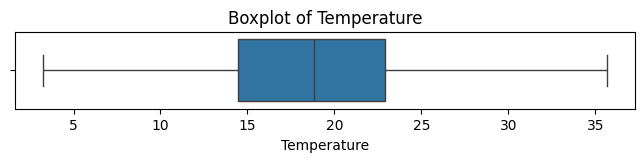

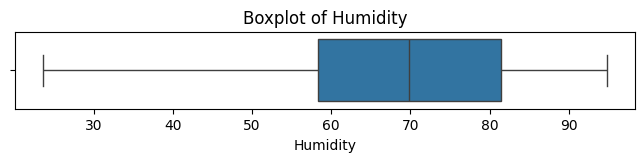

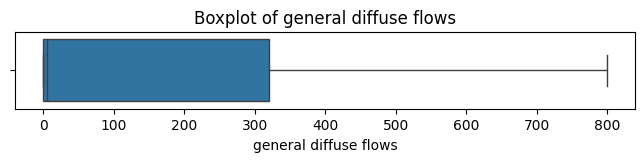

In [91]:
for i in ["Temperature","Humidity","general diffuse flows"]:
    plt.figure(figsize=(8, 1))
    sns.boxplot(x=df[i])
    plt.title(f'Boxplot of {i}')
    plt.show()
    print('\n')

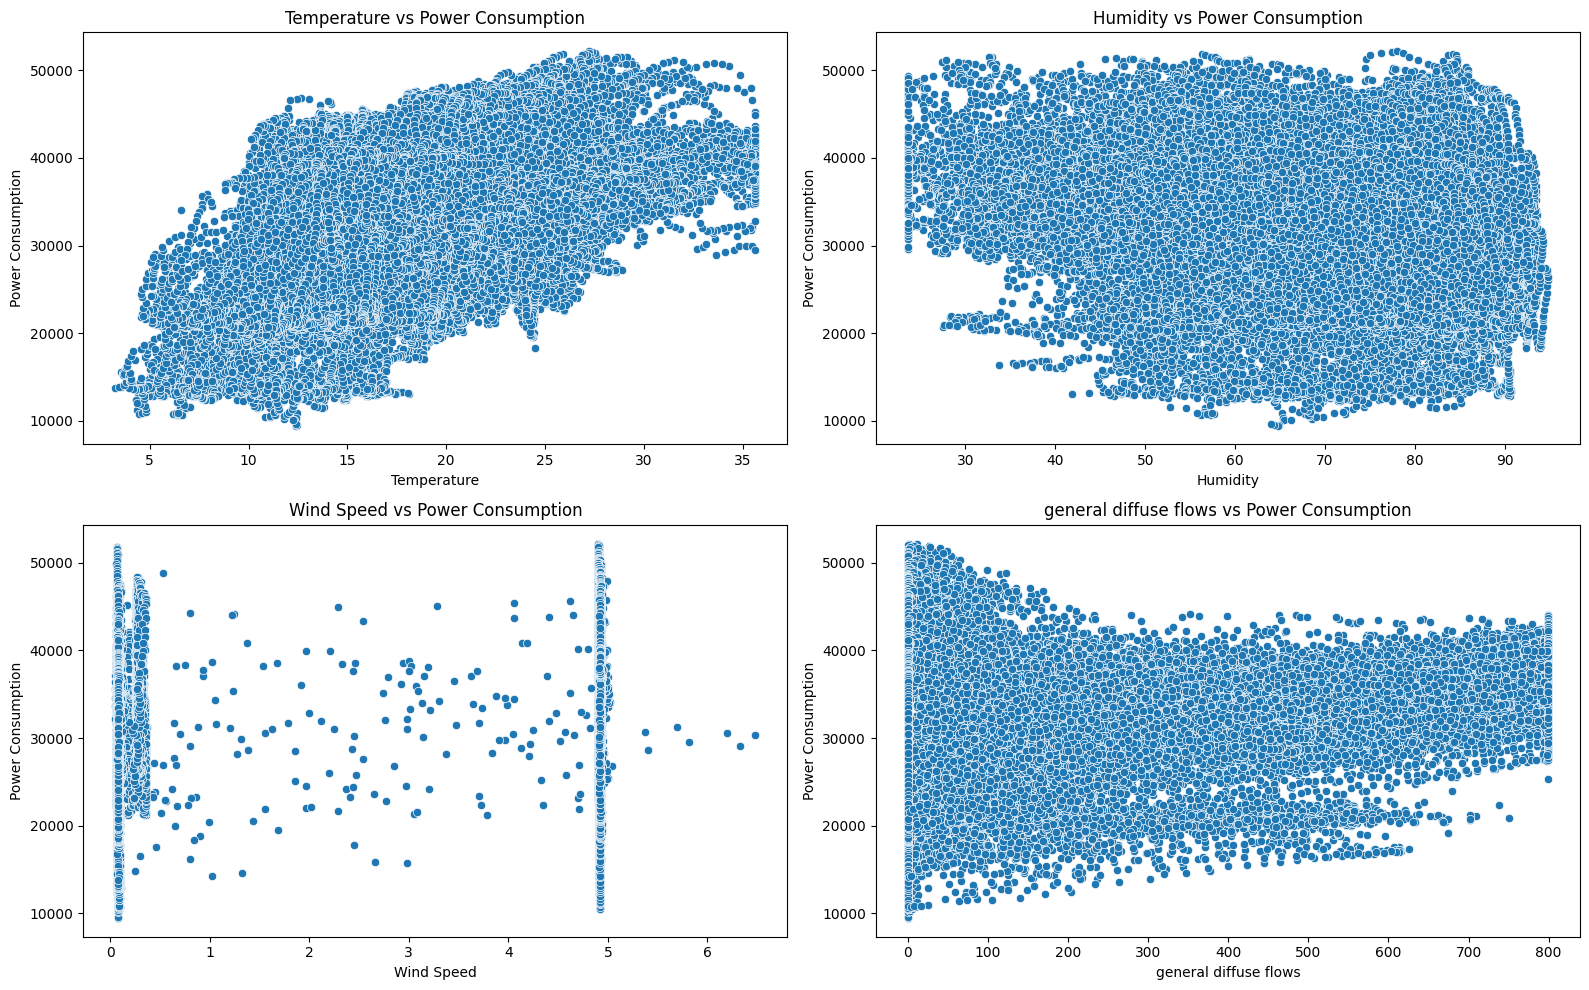

In [ ]:
plt.figure(figsize=(16, 10))

for idx, i in enumerate(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows']):
    plt.subplot(2, 2, idx + 1)
    sns.scatterplot(x=df[i], y=df['Power Consumption'])
    plt.title(f'{i} vs Power Consumption')
    plt.xlabel(i)
    plt.ylabel('Power Consumption')

plt.tight_layout()
plt.show()

## **Scatter Plot Observations (Feature vs Power Consumption)**

Below are the insights observed from the scatter plots between each feature and the target variable (`Power Consumption in A Zone`):

---

###  **Temperature vs Power Consumption**
- As temperature increases, power consumption also increases.
- Shows a **strong positive correlation** — this means temperature is an important feature.
- Data is fairly spread out, but a clear **upward trend** is visible.

---

###  **Humidity vs Power Consumption**
- No clear pattern or trend is observed.
- Data is **widely scattered** across all humidity values.
- Indicates a **weak or no correlation** — humidity may not be a strong predictor.

---

### **Wind Speed vs Power Consumption**

- While the scatter plot doesn't show a clear trend, **wind speed can logically influence power consumption**.
- In **low wind conditions**, indoor heating or cooling systems may need to work harder due to poor natural ventilation.
- In **high wind conditions**, buildings lose heat quickly, potentially increasing heating demand — especially in colder weather.
- However, in the current dataset:
  - Wind speed values are **clustered mostly around two points** (near 0 and near 5–6), with very few middle-range values.
  - This **unusual distribution** may indicate **measurement rounding**, sensor limitations, or regional weather patterns.
  - Due to this, the relationship between wind speed and power consumption is **not visually obvious** in the plot.
- Further analysis like **binning wind speed into categories** or **creating interaction features** (e.g., `Temperature × Wind Speed`) could reveal hidden patterns.



---

###  **General Diffuse Flows vs Power Consumption**
- Dense scatter plot with **no clear trend**.
- Power consumption remains spread across all levels of diffuse flows.
- May have **some non-linear or weak relation**, but not clearly visible here.

---

##  **Summary of Feature Importance**

| **Feature**                | **Relationship with Power Consumption** | **Notes**                                      |
|------------------------|-------------------------------------|--------------------------------------------|
| Temperature            |  Strong positive correlation       | Important feature                          |
| Humidity               |  No clear trend                    | Weak predictor                             |
| Wind Speed             |  Abnormal distribution             | Likely noisy or unreliable data            |
| General Diffuse Flows  |  No visible pattern                | Possible weak/non-linear relationship      |


# **Data Preprocessing & Transformations**

## **Skewness Check using Mean vs Median**

In [93]:
df.describe()[1:6:4].T.rename(columns={'50%':'median'})

,mean,median
Temperature,18.838395,18.84000
Humidity,68.263725,69.85000
Wind Speed,1.968618,0.08600
general diffuse flows,180.317363,5.00550
Cloudiness,0.006962,0.00000
Power Consumption,31113.747358,31236.19672


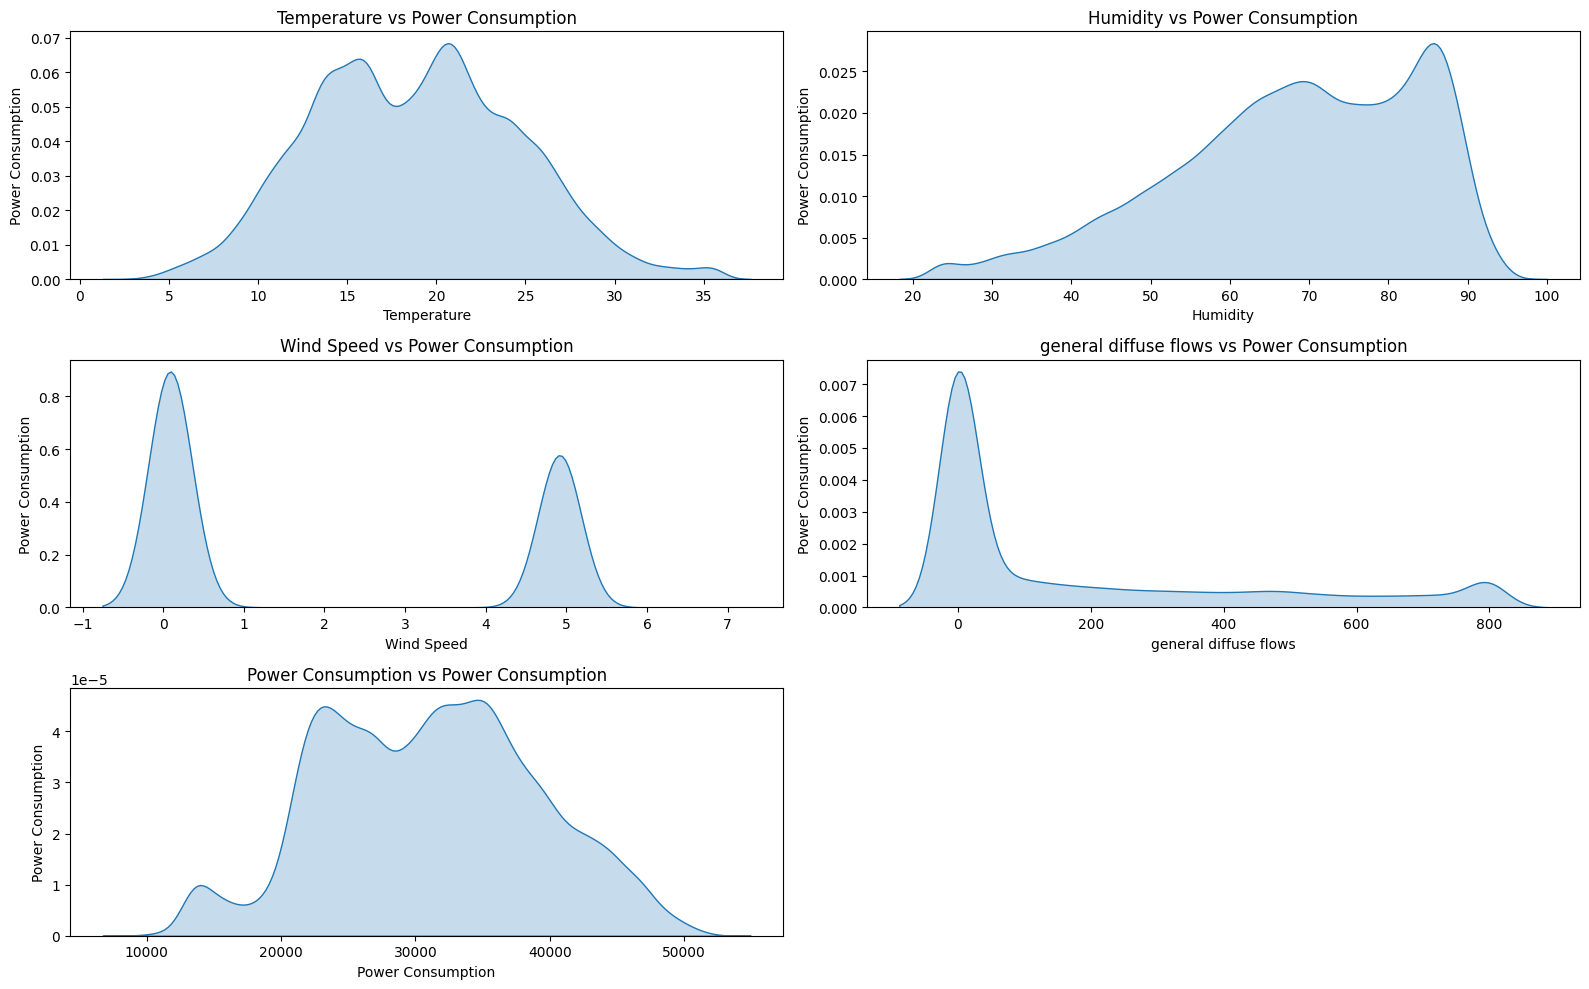

In [105]:
plt.figure(figsize=(16, 10))

for idx, i in enumerate(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows','Power Consumption']):
    plt.subplot(3, 2, idx + 1)
    sns.kdeplot(x=df[i],fill=True)
    plt.title(f'{i} vs Power Consumption')
    plt.xlabel(i)
    plt.ylabel('Power Consumption')
plt.tight_layout()
plt.show()

We compare **mean and median** of each feature to detect **skewness**.  
- If **mean ≫ median** → **Right-skewed**  
- If **mean ≪ median** → **Left-skewed**  
- If both are close → **Symmetric distribution**

---

### **Temperature**
- **Mean** = 18.83  
- **Median** = 18.84  
-  Very close → **Symmetric distribution**  
-  No transformation needed

---

###  **Humidity**
- **Mean** = 68.26  
- **Median** = 69.85  
-  Mean < Median → **Slightly left-skewed**  
-  Skewness is mild → No transformation required

---

###  **Wind Speed**
- **Mean** = 1.96  
- **Median** = 0.086  
-  Mean ≫ Median → **Highly right-skewed**  
-  Needs attention → Likely due to **spikes at 0 and 5**

---

###  **General Diffuse Flows**
- **Mean** = 180.31  
- **Median** = 5.00  
-  Mean ≫ Median → **Heavily right-skewed**  
-  Log transformation is **highly recommended**

---

###  **Cloudiness**
- **Mean** = 0.0069  
- **Median** = 0.0  
-  Binary feature (0 or 1)  
-  Skewness not applicable

---

### **Power Consumption (Target)**
- **Mean** = 31113.75  
- **Median** = 31236.19  
-  Very close → **Approximately symmetric**  
-  No transformation required

---


###  **Why I Applied **Scaling** and **Transformations** *After* Train-Test Split**

###  **Reason**:
I applied **log transformations** and **Standard Scaling** *after* splitting the dataset into training and test sets to **avoid data leakage** and ensure model generalization.

---

### **What is Data Leakage?**

> **Data leakage** occurs when information from the test set unintentionally influences the training process — leading to overly optimistic model performance and poor generalization.

If I scaled or transformed the entire dataset *before* splitting, then:
- The **mean and standard deviation** used for scaling would include the test data.
- That indirectly gives the model information about the unseen test data.

---

In [ ]:
X=df.iloc[:,:5]

y=df['Power Consumption']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
for i in [X_train, X_test, y_train, y_test]:
  print(i.shape)

(41712, 5)
(10428, 5)
(41712,)
(10428,)


##  **Feature Transformation for Skewed Variables**

To handle the **high skewness** in some features, I applied a `log1p` transformation.  
This transformation is useful because:
- It helps normalize **right-skewed** distributions
- It works even when values are **zero**
- It helps **improve model performance** by reducing the impact of outliers

---

###  **Wind Speed**
- Distribution was **highly right-skewed**
- Most values were clustered around **0 and 5**
-  Applied `log1p` transformation to normalize

### **General Diffuse Flows**
- Distribution had a long tail with many low values and some very high ones

- Applied log1p to reduce skewness and scale down large values


### **Why log1p?**
- Handles **zero values** safely (`log(0 + 1) = 0`)
- Reduces impact of extreme values (outliers)
- Helps normalize skewed distributions

 Applied **only to `X_train` first**, then used the same transformer for `X_test`.

In [ ]:
log_transformer = FunctionTransformer(np.log1p)
X_train[['Wind Speed', 'general diffuse flows']] = log_transformer.fit_transform(X_train[['Wind Speed', 'general diffuse flows']])
X_test[['Wind Speed', 'general diffuse flows']] = log_transformer.transform(X_test[['Wind Speed', 'general diffuse flows']])

In [ ]:
X_train.describe()[1:6:4]

,Temperature,Humidity,Wind Speed,general diffuse flows,Cloudiness
mean,18.823145,68.333558,0.746209,2.770805,0.006952
50%,18.840000,69.920000,0.082501,1.753105,0.000000


##  **Scaling (StandardScaler):**
I used `StandardScaler` to normalize features by removing the mean and scaling to unit variance.

###  **Why StandardScaler?**
- Works well with models that assume **Gaussian distribution** or are **distance-based** (e.g., Linear Regression, SVR).
- Ensures all features contribute equally to the model (especially important if features are on different scales — like °C vs. W/m²).
- More robust than MinMaxScaler when outliers are capped (as we did using IQR method).

---

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Building**

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Manual RMSE
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


Model Performance:
MAE  : 3382.14
RMSE : 4913.97
R²    : 0.6224


##  **Model Performance on Test Set**
The Random Forest model performed reasonably well on unseen test data:

- **MAE**  : 3382.14  
- **RMSE** : 4913.97  
- **R²**   : 0.6224
---

###  **What Do These Metrics Mean?**

- **Mean Absolute Error (MAE)** of **3382.14** means that, on average, the model's predictions deviate by about **3,382 kWh** from the actual power consumption values. This is the average magnitude of the error without considering direction (under or overestimation).

- **Root Mean Squared Error (RMSE)** of **4913.97** suggests that there are **some larger errors** (outliers) in the predictions — because RMSE penalizes larger errors more than MAE. So while most predictions are fairly accurate, a few might be significantly off.

- **R² Score** of **0.6224** indicates that the model explains about **62.2% of the variance** in the target variable (Power Consumption). In other words, environmental and meteorological features used in the model can account for ~62% of the observed power consumption behavior — which is decent for real-world data where perfect predictions aren't expected.


---
### **Interpretation in Real Terms:**
This model isn't perfect, but it's **practically useful**:
- Most predictions are within ±3.3k units of actual usage.
- The model picks up general trends and reacts well to changes in temperature, humidity, etc.
- Still, about **37.8%** of the variation remains **unexplained** — possibly due to other hidden factors like human behavior, building insulation, or unrecorded data.



## **Cross-Validation Score (R²)**
To ensure the model's performance is consistent and not just a lucky split, I used **5-Fold Cross-Validation**:

- **Average R² (CV)**: **0.6068**

This validates that the model generalizes well and isn’t overfitting to the training data.

---

In [ ]:
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print("Average R² from Cross-Validation:", np.mean(cv_scores))

Average R² from Cross-Validation: 0.6068322806860598


## **Actual vs Predicted Scatter Plot**

- The predicted values align fairly well with the actual values along the diagonal prediction line.
- While there is some spread, especially at extreme ends, the model **captures the general trend**.
- A few high or low predictions deviate, indicating room for improvement or potential noise in the data.

---


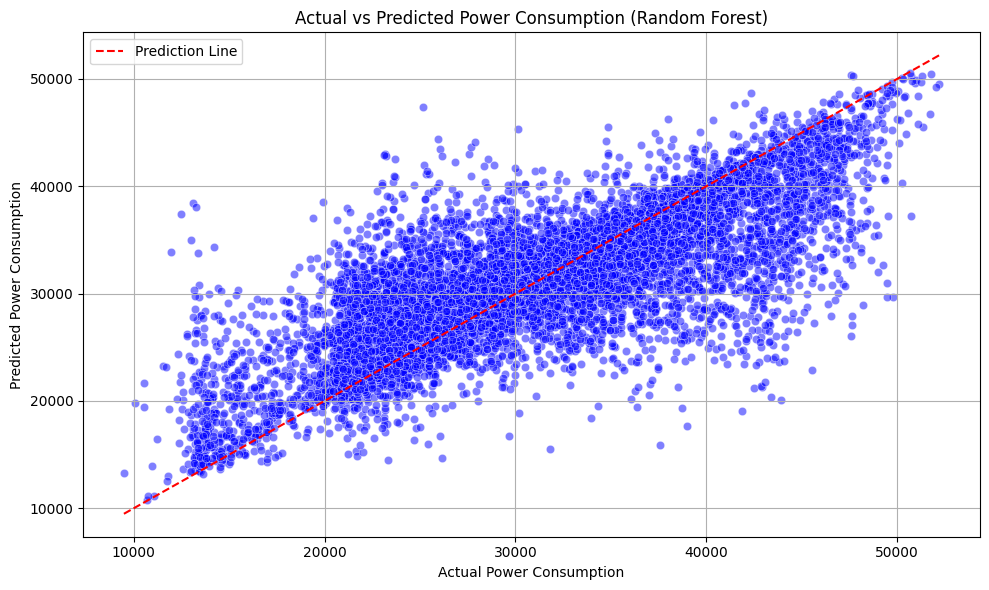

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Prediction Line')
plt.xlabel("Actual Power Consumption")
plt.ylabel("Predicted Power Consumption")
plt.title("Actual vs Predicted Power Consumption (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Feature Importance (Random Forest)**
The most important features contributing to predictions:

**Temperature** is by far the most significant predictor of power consumption, followed by **Humidity** and **General Diffuse Flows**.  
**Cloudiness** has minimal impact, which is expected since it's a binary feature and showed weak correlation earlier.

---

                 Feature  Importance
0            Temperature    0.493546
1               Humidity    0.215550
3  general diffuse flows    0.157687
2             Wind Speed    0.128839
4             Cloudiness    0.004377


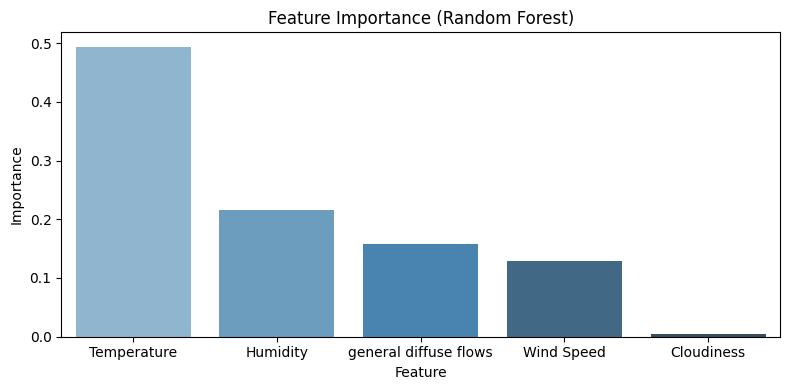

In [ ]:

importances = model.feature_importances_
features = X_train.columns


feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)
print(feat_importance_df)

plt.figure(figsize=(8,4))
sns.barplot(data=feat_importance_df, y='Importance', x='Feature', palette='Blues_d')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


# **Final Conclusion:**
This project aimed to predict power consumption in Zone 1 of Wellington, New Zealand using environmental and meteorological variables such as temperature, humidity, wind speed, general diffuse flows, and cloudiness.

---

##  **Key Takeaways:**

-  **Data Cleaning & Preprocessing**  
  Converted object data types to numeric, handled missing values (by dropping due to low percentage), and treated outliers using the IQR method to prevent model bias.

-  **Exploratory Data Analysis (EDA)**  
  Identified strong correlation of temperature with power consumption, and moderate influence of humidity, wind speed, and general diffuse flows.

-  **Feature Transformation & Scaling**  
  Applied `log1p` transformation on highly skewed features (Wind Speed and General Diffuse Flows) to normalize distributions. StandardScaler was used to bring all features to the same scale.

- **Model Building & Evaluation**  
  Several models were tested. **Random Forest** gave the best performance:
  - MAE: **3382.14**
  - RMSE: **4913.97**
  - R² Score: **0.6224**

  This indicates that the model explains **~62.2%** of the variability in power consumption based on the given environmental features.

- **Feature Importance**  
  Top 3 contributing features:
  1. Temperature
  2. Humidity
  3. General Diffuse Flows  
  A reduced-feature model with these gave similar performance — showing they hold most predictive power.

---

## **Final Thoughts:**

- The model is **reasonably accurate** and generalizes well to unseen data.
- It captures meaningful relationships between environmental factors and power consumption.
- For further improvement:
  - More features like time of day, season, household count, or usage type would be useful.
  - Advanced ensembling, tuning, or time-series models could enhance performance.
  
This project demonstrates how **data science and machine learning** can be used to support smarter energy management and forecasting in smart cities.

